# Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torch.nn.functional import interpolate
import torchvision.transforms.functional as TF

## Dataset class

In [2]:
class CifarDataset(Dataset):
    """
    Class for storing dataset used for feeding Neural Network. 
    """
    
    def __init__(self, root_dir, labels, class_dict, transform=None):
        self.root_dir = root_dir
        self.labels = pd.read_csv(labels, header=0)
        self.transform = transform
        self.class_dict = class_dict

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_id = self.labels.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, str(img_id) + '.png'))
        label = self.class_dict[self.labels.iloc[index, 1]]

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)
    
    def display_image(self, index=0, resize=128):
        """
        Function for displaying single image from dataset, indexed by 'index' parameter.
        Params:
        index - index of image
        resize - value used for resizing the image. For example if resize=128, we get 128x128 pixels image.
        """
        img, _ = self[index]
        label = self.labels.iloc[index, 1]
        resized_img = interpolate(img.unsqueeze(0), size=(resize, resize), mode='bilinear', align_corners=False).squeeze(0)
        plt.title(label)
        plt.imshow(resized_img.permute(1,2,0))
        
    def display_sample_images(self, sample=None, sample_size=4, resize=128):
        """
        Function for displaying sample of images from dataset. The sample can be random or chosen by the user.
        Params:
        sample - list of indices of the images in Dataset
        sample_size - number of randomly selected images, if sample == None
        resize - value used for resizing the image. For example if resize=128, we get 128x128 pixels image.
        """
        if sample:
            random_sample = sample
        else:
            random_sample = random.sample(range(len(self)), sample_size)
        fig, axes = plt.subplots(nrows = int(np.ceil(sample_size/2)) , ncols = 2, figsize=(6, sample_size))
        row, col = 0, 0
        
    
        for i in random_sample:
            img, _ = self[i]
            label = self.labels.iloc[i, 1]
            resized_img = interpolate(img.unsqueeze(0), size=(resize, resize), mode='bilinear', align_corners=False).squeeze(0)

            if sample_size <=2:
                axes[col].imshow(resized_img.permute(1,2,0))
                axes[col].set_title(label)
            else:
                axes[row, col].imshow(resized_img.permute(1,2,0))
                axes[row, col].set_title(label)
            
            if col == 0:
                col += 1
            else:
                row += 1
                col = 0
        
        fig.suptitle('Random sample')
        fig.subplots_adjust(hspace=0.35)
        plt.show()


## Cifar10 - data overview

In [3]:
# Path to directory containing images for training and validation
TRAIN_DIR = 'Cifar10\\train'
VAL_DIR = 'Cifar10\\val'

# Path to Dataframe with labels for training and validation data
TRAIN_LABELS = 'Cifar10\\trainLabels.csv'
VAL_LABELS = 'Cifar10\\valLabels.csv'

# DATA_DIR = os.path.join(MODULE_DIR, '..', ROOT_DIR)
# LABELS_DIR = os.path.join(MODULE_DIR, '..', LABELS)
# All unique labels
CLASS_NAMES = ['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship', 'cat', 'dog',
 'airplane']
# Dictionary for encoding classes
CLASS_DICT = {CLASS_NAMES[i]: i for i in range(len(CLASS_NAMES))}

In [54]:
# Generate Dataset and DataLoader instances for training data
cifar_train = CifarDataset(root_dir = TRAIN_DIR, labels=TRAIN_LABELS, transform=transforms.ToTensor(), class_dict=CLASS_DICT)
cifar_val = CifarDataset(root_dir = VAL_DIR, labels=VAL_LABELS, transform=transforms.ToTensor(), class_dict=CLASS_DICT)

Image size: torch.Size([3, 32, 32])


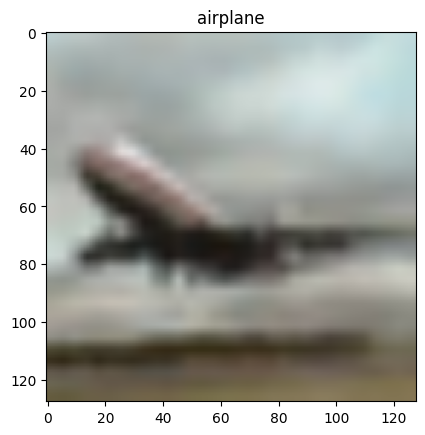

In [5]:
# Images are 32 x 32 pixels. 3 RGB channels.
print("Image size:", cifar_val[0][0].size())
cifar_val.display_image(index=4, resize=128)

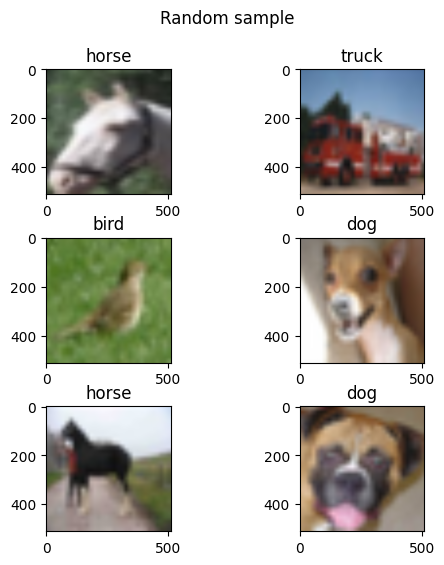

In [6]:
cifar_train.display_sample_images(sample_size=6, resize=512)

## Augmentation techniques

#### Add noise to data

In [7]:
class GaussianNoise(object):
    """
    Class used for adding Gaussian noise to image. 
    Use after transforms.ToTensor(), if used in transforms.Compose() pipeline. 
    """
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
        
    def __call__(self, img):
        return img + torch.randn(tuple(img.size())) * self.std + self.mean

### Standard augmentation techniques

#### Rotation + colorJitter + crop + gaussian noise

In [8]:
img_size = 32
transformer = transforms.Compose([transforms.Pad(padding=(4, 4, 4, 4), fill=0, padding_mode='constant'),
                                  transforms.RandomRotation(degrees=(-30,30)),
                                  transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
                                  transforms.RandomCrop(img_size),
                                  transforms.ToTensor(),
                                  GaussianNoise(mean=0, std=0.001)])
                                    


cifar_aug1 = CifarDataset(root_dir = TRAIN_DIR, labels=TRAIN_LABELS, transform=transformer, class_dict=CLASS_DICT)
merged_dataset1 = ConcatDataset([cifar_train, cifar_aug1])
print(len(merged_dataset1))

80000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


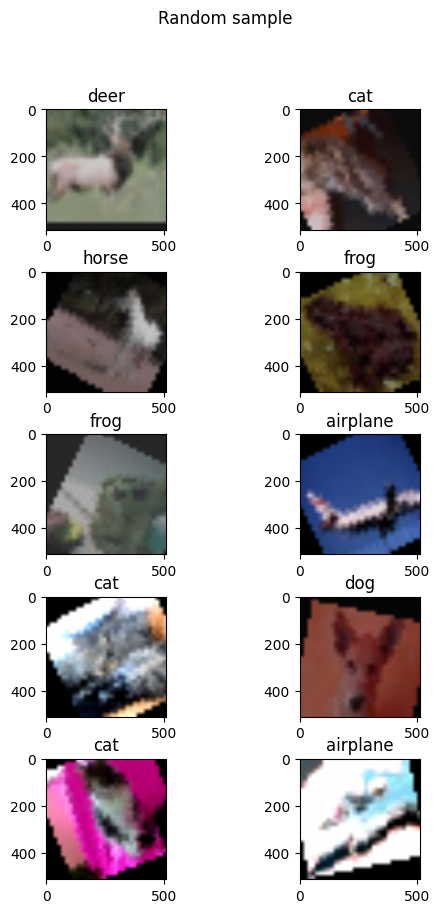

In [9]:
cifar_aug1.display_sample_images(sample_size=10, resize=512)

### Advanced augmentation techniques

#### Image mixing

In [28]:
class MixedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.permutation = list(range(len(self.dataset1)))
        random.shuffle(self.permutation)
    
    def __len__(self):
        return len(self.dataset1)

    def __getitem__(self, index):
        # get images from the two Datasets
        image1, label = self.dataset1[index]
        image2, _ = self.dataset2[self.permutation[index]]

        # mix the two images using tensor_mixer
        mixed_image = MixedDataset.tensor_mixer(image1, image2)

        # return the mixed image and a dummy label
        return mixed_image, label
    
    @staticmethod
    def tensor_mixer(tensor1, tensor2):
        return torch.mean(torch.stack([tensor1, tensor2]), dim=0)

    def display_sample_images(self, sample=None, sample_size=4, resize=128):
        """
        Function for displaying sample of images from dataset. The sample can be random or chosen by the user.
        Params:
        sample - list of indices of the images in Dataset
        sample_size - number of randomly selected images, if sample == None
        resize - value used for resizing the image. For example if resize=128, we get 128x128 pixels image.
        """
        if sample:
            random_sample = sample
        else:
            random_sample = random.sample(range(len(self)), sample_size)
        fig, axes = plt.subplots(nrows = int(np.ceil(sample_size/2)) , ncols = 2, figsize=(6, sample_size))
        row, col = 0, 0
        
    
        for i in random_sample:
            img, _ = self[i]
            label = self.dataset1.labels.iloc[i, 1]
            resized_img = interpolate(img.unsqueeze(0), size=(resize, resize), mode='bilinear', align_corners=False).squeeze(0)

            if sample_size <=2:
                axes[col].imshow(resized_img.permute(1,2,0))
                axes[col].set_title(label)
            else:
                axes[row, col].imshow(resized_img.permute(1,2,0))
                axes[row, col].set_title(label)
            
            if col == 0:
                col += 1
            else:
                row += 1
                col = 0
        
        fig.suptitle('Random sample')
        fig.subplots_adjust(hspace=0.35)
        plt.show()

In [86]:
class MixUpTransform(object):
    def __init__(self, alpha=0.5, dataset = None):
        self.alpha = alpha
        self.dataset = dataset

    def __call__(self, img):
        mix_img, _ = self.dataset[int(torch.randperm(len(self.dataset))[0])]

        mixed = img * self.alpha + mix_img * (1 - self.alpha) 

        return mixed

In [84]:
transformer = transforms.Compose([transforms.Pad(padding=(4, 4, 4, 4), fill=0, padding_mode='constant'),
                                  transforms.RandomCrop(img_size),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ToTensor(),
                                  MixUpTransform(alpha=0.6, dataset=cifar_train)])

mixed = CifarDataset(root_dir = TRAIN_DIR, labels=TRAIN_LABELS, transform=transformer, class_dict=CLASS_DICT)

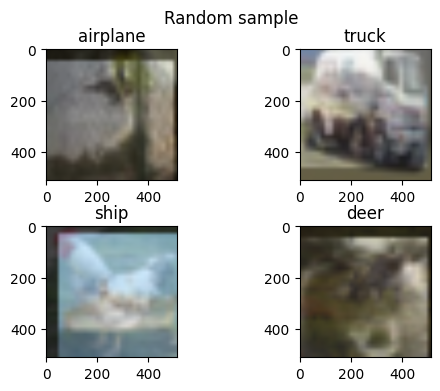

In [85]:
mixed.display_sample_images(sample_size=4, resize=512)

### Cutout

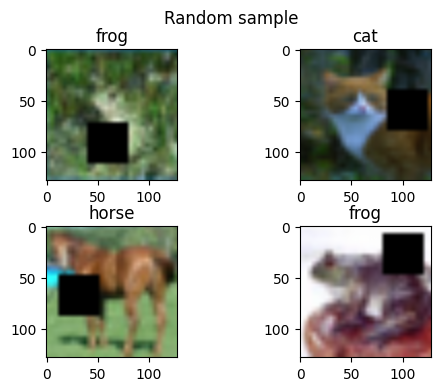

In [ ]:
class Cutout(object):
    def __init__(self, size=16, p=0.5):
        self.size = size
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img

        w, h = img.size
        x = random.randint(0, w - self.size)
        y = random.randint(0, h - self.size)
        mask = np.ones((h, w), np.float32)
        mask[y:y+self.size, x:x+self.size] = 0.
        mask = torch.from_numpy(mask)
        img = TF.to_tensor(img)
        img = img * mask.unsqueeze(0)
        img = TF.to_pil_image(img)

        return img

transformer3 = transforms.Compose([Cutout(size=10, p=1),
                                  transforms.ToTensor()])

cifar_aug4 = CifarDataset(root_dir = TRAIN_DIR, labels=TRAIN_LABELS, 
                          transform=transformer3, class_dict=CLASS_DICT)
cifar_aug4.display_sample_images(sample_size=4)